In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pyaudio
import config
import glob

plt.rcParams['figure.figsize'] = [15, 8]

root_path = '../data/'  #  config.paths["data_out"] 
sess_name = 'time_testall__timing_task'
file = root_path +  sess_name + ".xdf"

#vids=  config.paths["nas"] + "tt_timing_task_brio7_1622838867.7885964.avi"
vids_bio = glob.glob(root_path + sess_name.replace("__", "_") + "*.avi")
vids_intel = glob.glob(root_path + sess_name.replace("__", "_") + "*.bag")


In [2]:

def read_vid(cap):
    vid_mat = []    
    f_num = 0
    while True:
        ret, frame = cap.read()        
        if not ret:
            break
        # vid_mat.append(np.average(frame,2))
        vid_mat.append(np.average(frame))        
        f_num += 1
        
    # vid_mat = np.stack(vid_mat, 2)    
    return vid_mat#, f_num

    
def plot_frames(vid_mat_list, frame_nums):
    
    n_cams = len(vid_mat_list)
    fig, axs = plt.subplots(1, n_cams)
    
    for ax, cap, frame_num in zip(axs, vid_mat_list, frame_nums):
        frame = cap[:,:, frame_num]
        ax.imshow(frame)

    
def plot_averg(vid_crp_list, frame_events_list):
    
    n_cams = len(vid_crp_list)
    fig, axs = plt.subplots(n_cams,1)
    
    for ax, cap, evts in zip(axs, vid_crp_list, frame_events_list):
        cap_m =cap # np.mean(cap,(0,1))  
        for ev in evts:
            ax.axvline(ev)
            
        ax.plot(cap_m, ".-", color='r')
            

def find_closest(marker_stmp, vid_stmps):
   inx =  np.argmin(np.abs(vid_stmps['time_stamps'] - marker_stmp))
   frame_num, = vid_stmps['time_series'][inx]
   return int(frame_num)

    
def sound(array, fs=43):
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=len(array.shape), rate=fs, output=True)
    stream.write(array.tobytes())
    stream.stop_stream()
    stream.close()
    p.terminate()
    
def record(duration=3, fs=44100):
    nsamples = duration*fs
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16, channels=1, rate=fs, input=True,
                    frames_per_buffer=nsamples)
    buffer = stream.read(nsamples)
    array = np.frombuffer(buffer, dtype='int16')
    stream.stop_stream()
    stream.close()
    p.terminate()
    return array


Marker samples:8, duration: 16.283260499942116, fps:0.49130209518102586
IntelFrameIndex_cam3 samples:883, duration: 18.98295240002335, fps:46.51541980366098
BrioFrameIndex_4 samples:1139, duration: 18.99203110000235, fps:59.97252184364099
BrioFrameIndex_7 samples:760, duration: 18.991806900012307, fps:40.01725607264402
IntelFrameIndex_cam1 samples:987, duration: 18.99608480001916, fps:51.95807506602647
Mouse samples:19, duration: 0.1648064999608323, fps:115.28671505380865
Audio samples:818, duration: 18.988928800012218, fps:43.07773274706648
IntelFrameIndex_cam2 samples:1157, duration: 19.001880099996924, fps:60.888711743854614


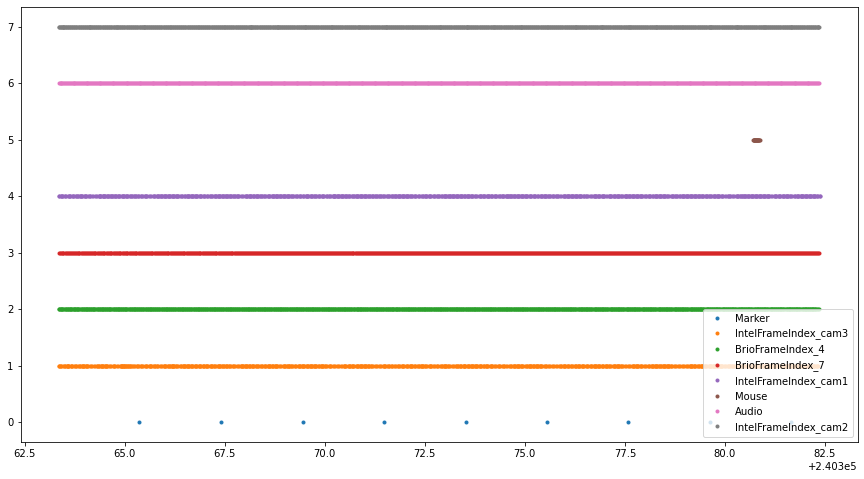

In [3]:

data, header = pyxdf.load_xdf(file)

plt.figure()
for i, d in enumerate(data):
    name = d['info']['name'][0]
    if d['time_stamps'].size == 0 :
        print(f"{name} samples:0")
        continue
    ts1, = d['footer']['info']['last_timestamp']
    ts0, = d['footer']['info']['first_timestamp']
    # ts0 = d['time_stamps'][2]
    # ts1 = d['time_stamps'][-1]
    tsn, = d['footer']['info']['sample_count']
    duration = float(ts1)-float(ts0)
    fps = 0 if int(tsn)==0 else int(tsn)/duration
    print(f"{name} samples:{tsn}, duration: {duration}, fps:{fps}")
    tmst = d['time_stamps']
    plt.plot(tmst, [i]*len(tmst), ".", label=name)
plt.legend()

Plotting time stamps vs time series


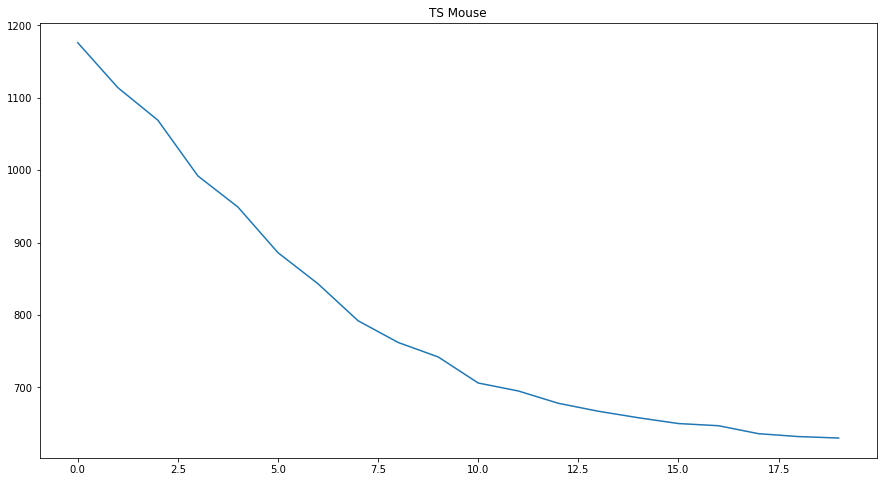

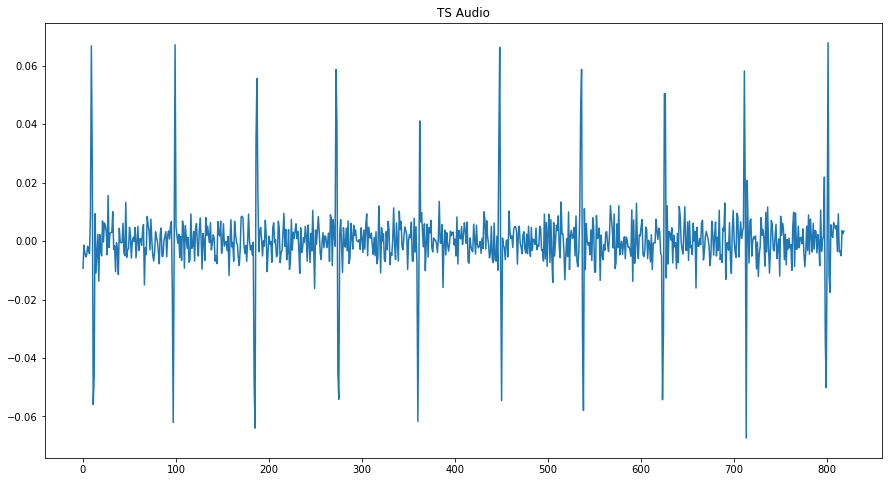

In [4]:

print("Plotting time stamps vs time series")
for i, d in enumerate(data):
    name = d['info']['name'][0]
    if name[:4] in ["Mark","Inte", "Brio"] :
        continue
    if d['time_stamps'].size == 0 :
        continue
        
    plt.figure()
    plt.title(f"TS {name}")
    tt = d['time_stamps']
    ts = d['time_series']
    if not isinstance(ts, list) and ts.shape[1]> 1:
        ts = ts[:,0]
    
    if isinstance(ts, list):
        ts = np.array(ts)
    
    ts_f = ts.flatten("C")
    plt.plot(ts_f, label=name)


Plotting diff time stamps


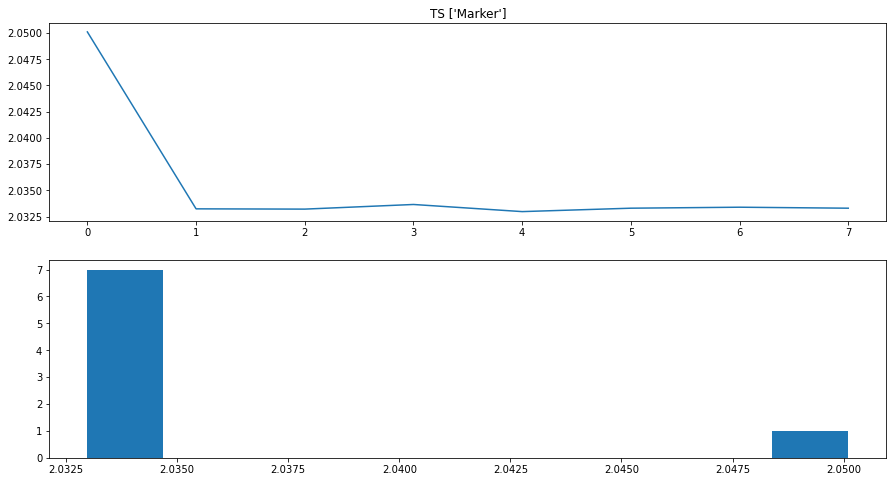

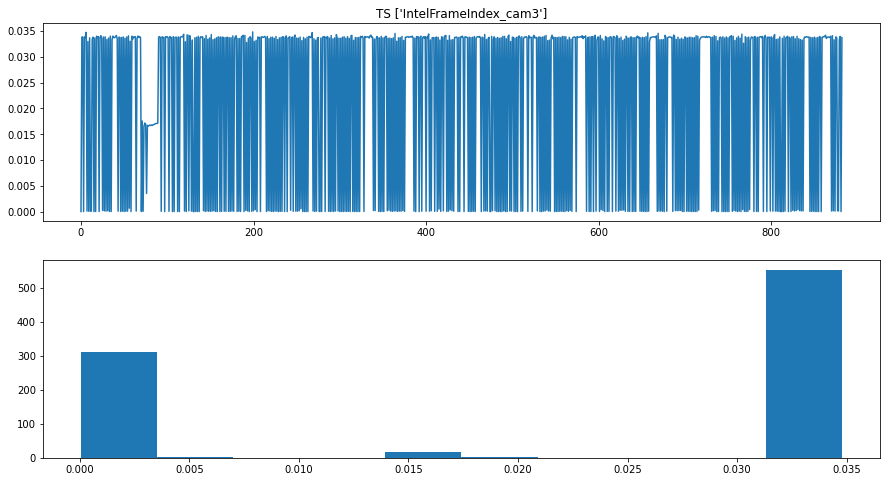

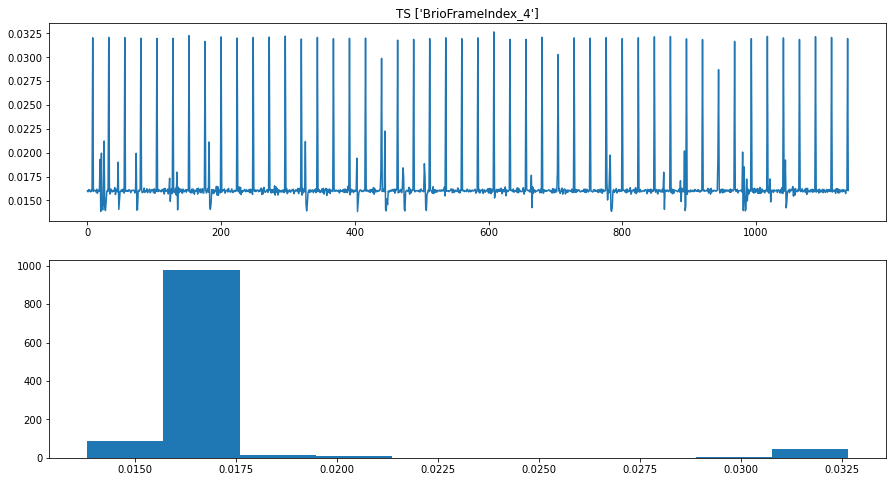

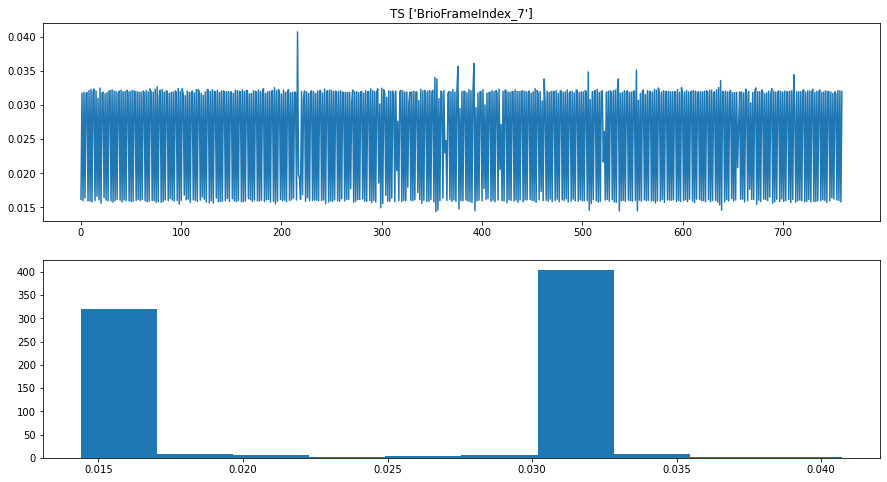

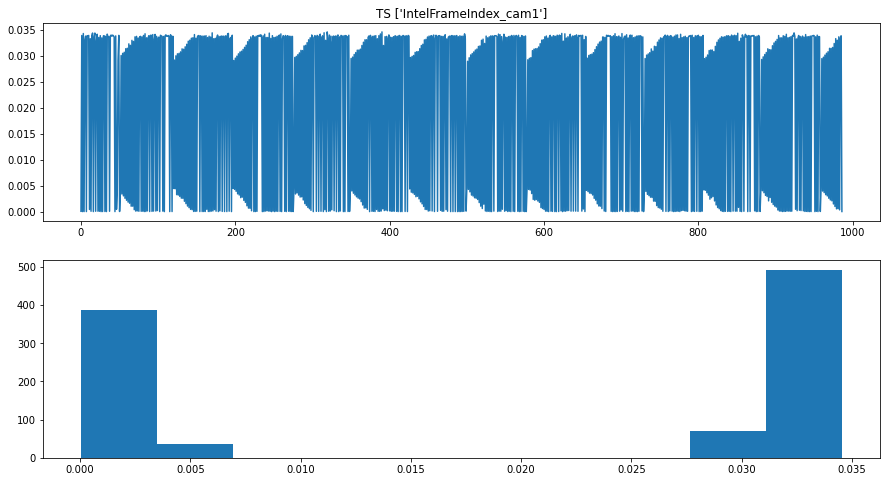

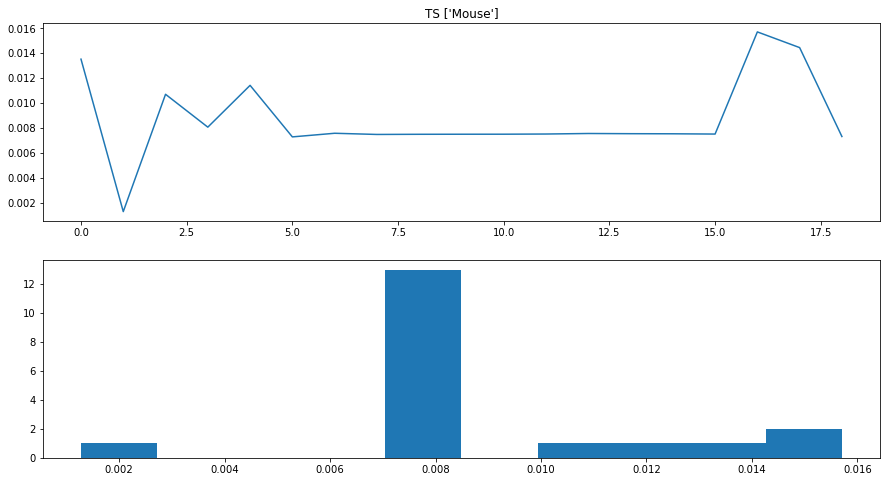

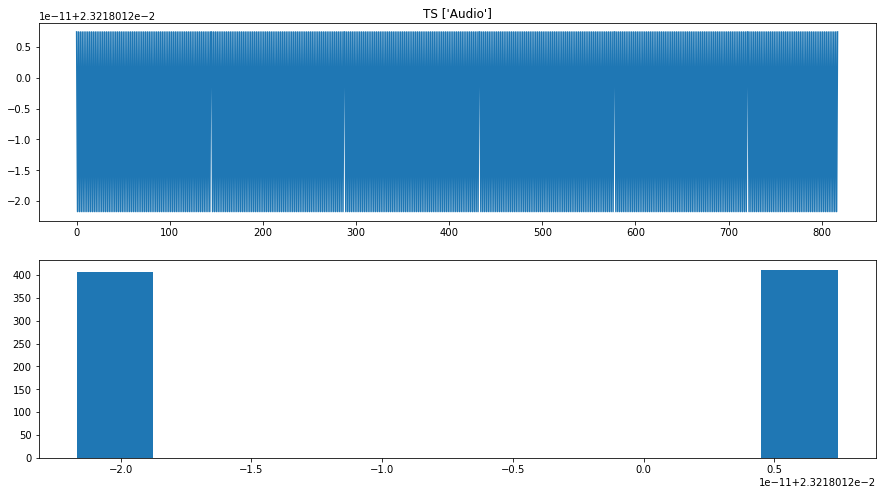

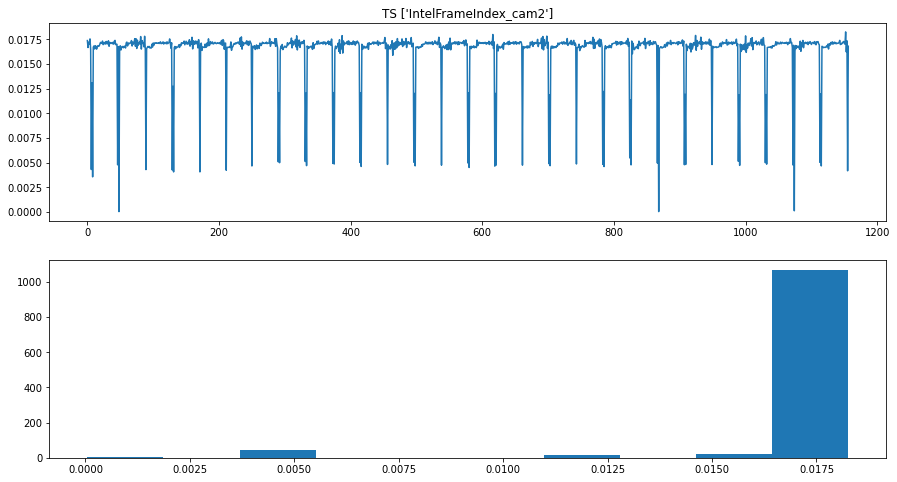

In [5]:
print("Plotting diff time stamps")
for i, d in enumerate(data):
    name = d['info']['name']

    if d['time_stamps'].size == 0 :
        print(f"{name} samples:0")
        continue
        
    fig, ax = plt.subplots(2,1)
    ax[0].set_title(f"TS {name}")
    tt = np.diff(d['time_stamps'])
    
    ax[0].plot(tt)
    ax[1].hist(tt)
    

Plotting: 
	 LSL sample index vs Intel frame index 
	 Intel frame diff

	 Intel frame diff hist 
	 LSL frame diff hist


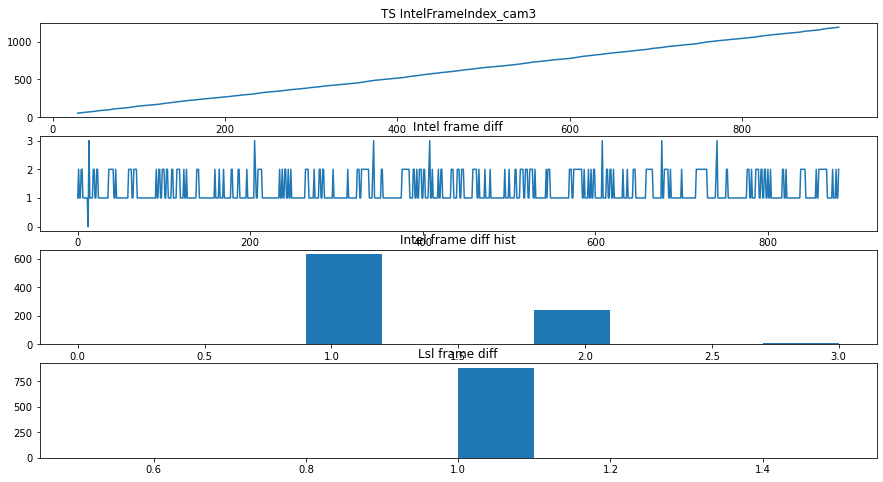

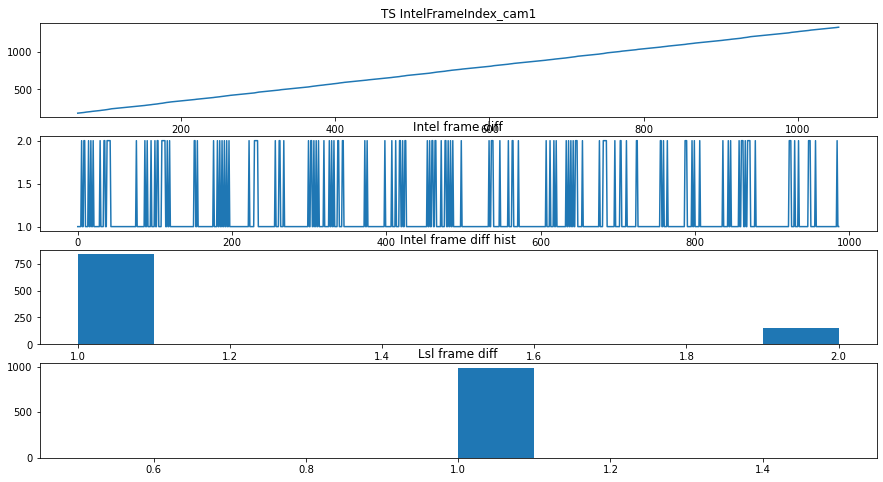

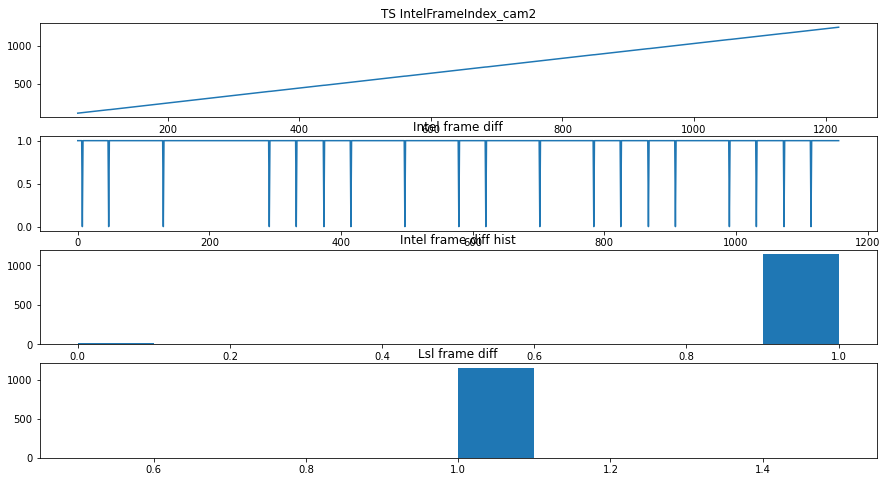

In [6]:
print("Plotting: \n\t LSL sample index vs Intel frame index \n\t Intel frame diff")
print("\n\t Intel frame diff hist \n\t LSL frame diff hist")
for i, d in enumerate(data):
    name = d['info']['name'][0]
    if name[:4]  != "Inte":
        continue
    inx_lsl  = d['time_series'][:,0]
    inx_int  = d['time_series'][:,1]
        
    fig, ax = plt.subplots(4,1)
    ax[0].set_title(f"TS {name}")
    dif_int = np.diff(inx_int)
    dif_lsl = np.diff(inx_lsl)
    
    ax[0].plot(inx_lsl, inx_int)
    ax[1].set_title("Intel frame diff")
    ax[1].plot(dif_int)
    
    ax[2].set_title("Intel frame diff hist")
    ax[2].hist(dif_int)
    
    ax[3].set_title("Lsl frame diff")
    ax[3].hist(dif_lsl)    
    
    

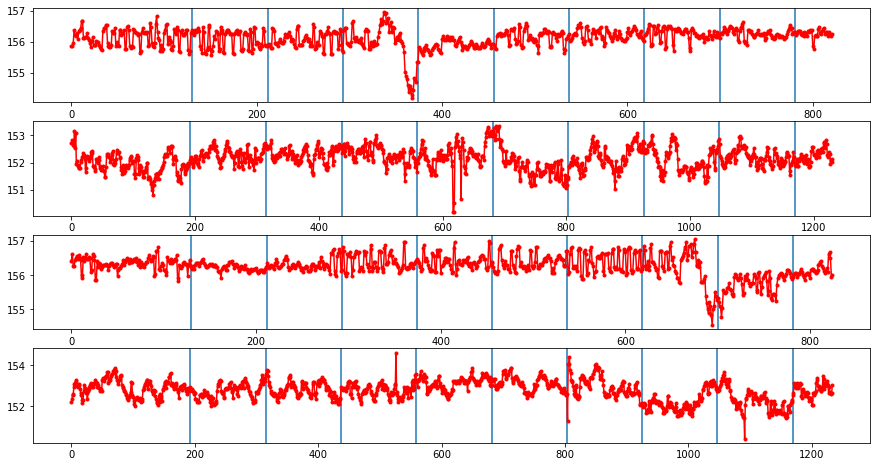

In [7]:
 
cams, intels = {}, {}
for ch in data:
    if ch['info']['name'][0] == 'Marker':
        markers = ch
    elif ch['info']['name'][0][:4] == 'Brio':
        cname = f"brio{ch['info']['name'][0][-1]}"
        cams[cname] = ch
    elif ch['info']['name'][0][:5] == 'Intel':
        cname = f"intel{ch['info']['name'][0][-1]}"
        intels[cname] = ch          
    elif ch['info']['name'][0] == 'Tobii':
        tobii = ch
    elif ch['info']['name'][0] == 'Audio':
        audio = ch        
    elif ch['info']['name'][0] == 'Mouse':
        mouse = ch         

###############################################################################
## Video
####


caps = [cv2.VideoCapture(vid) for vid in vids_bio]
chinfs = [cams[vid.split("_")[4]] for vid in vids_bio]

vid_mats = [read_vid(cap) for cap in caps]

frame_nums = [find_closest(markers['time_stamps'][0], caminf) for caminf in chinfs]

# plot_frames([vid_crp1, vid_crp2], frame_nums)
frm_events =  [ [find_closest(m, vid) for m in markers['time_stamps']] 
                for vid in chinfs ]
             
plot_averg(vid_mats, frm_events)



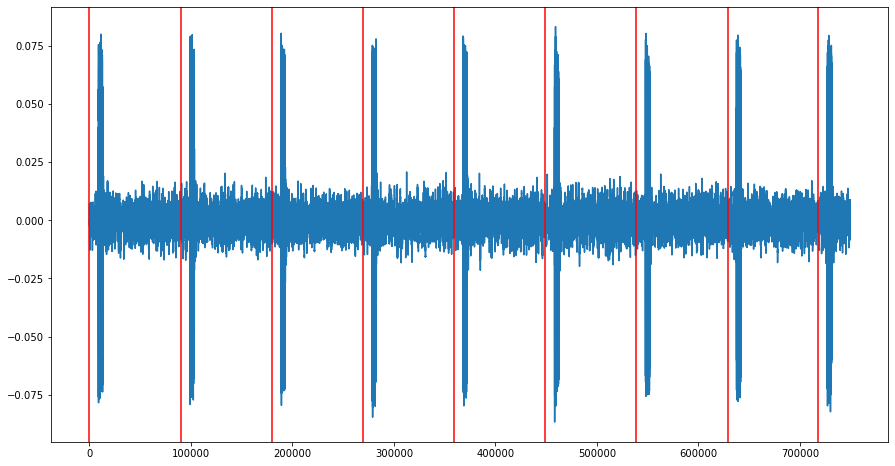

In [8]:

###############################################################################
## Audio
####

evts = [np.argmin(np.abs(audio['time_stamps'] - e)) for e in  markers['time_stamps']]
audio_data =  np.hstack(audio['time_series'][evts[0]:, :])
plt.figure(), plt.plot( np.hstack(audio['time_series'][evts[0]:, :]))

_ = [plt.axvline((e-evts[0])*1024, color='r') for e in evts]



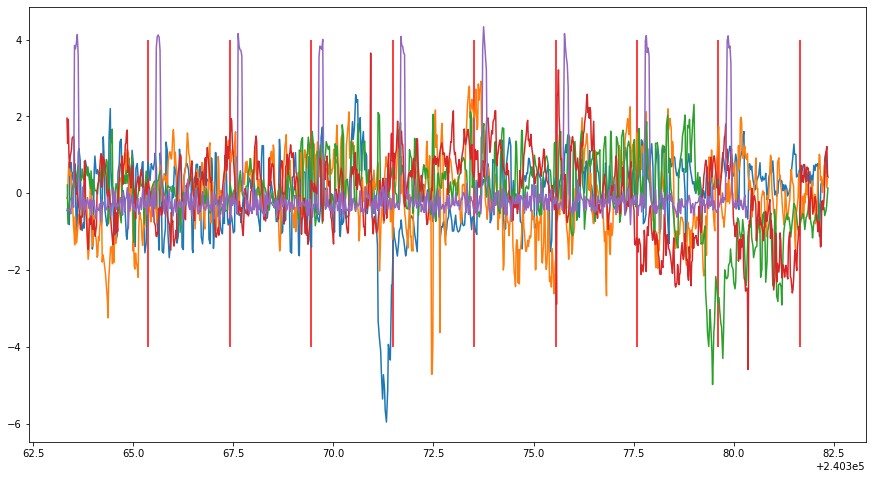

In [13]:

###############################################################################
vids_arr = [(np.array(vid)[cam['time_series']], cam['time_stamps']) for vid, cam in zip(vid_mats, chinfs)]

plt.figure(), 
for vid in vids_arr:
    plt.plot(vid[1], (vid[0] - vid[0].mean()) /vid[0].std())
 
audio_data =  audio['time_series'][evts[0]:, :].max(1)
tsmp_a = audio['time_stamps']
tmax = len(audio_data)

plt.plot(tsmp_a[:tmax], (audio_data - audio_data.mean())/audio_data.std())

tt = markers['time_stamps']
plt.vlines(tt,-4, 4, "red")